# Modularity
Modularity is a mathematical notion of how *assortative* a network is under some
partition of the network into different groups (or communities, or modules, etc.).
Here we apply a modularity maximization algorithm to the maggot network separated by
edge types and compare various properties of the partitions and modularities.

## Preliminaries

In [1]:
import datetime
import time

import matplotlib.pyplot as plt
import networkx as nx
import numpy as np
import pandas as pd
import seaborn as sns
from sklearn.metrics import adjusted_rand_score

from graspologic.partition import leiden, modularity
from graspologic.utils import symmetrize
from pkg.data import load_maggot_graph
from pkg.io import savefig
from pkg.plot import set_theme
from src.hierarchy import signal_flow
from src.visualization import CLASS_COLOR_DICT as palette
from src.visualization import adjplot

t0 = time.time()

set_theme()


def stashfig(name, **kwargs):
    foldername = "modularity"
    savefig(name, foldername=foldername, **kwargs)

/Users/bpedigo/miniconda3/envs/maggot-revamp/lib/python3.8/site-packages/umap/__init__.py:9: UserWarning: Tensorflow not installed; ParametricUMAP will be unavailable
  warn("Tensorflow not installed; ParametricUMAP will be unavailable")


### Load the data

In [2]:
edge_types = [
    "ad",
    "aa",
    "dd",
    "da",
    "sum",
]
colors = sns.color_palette("deep", desat=None)
edge_type_palette = dict(zip(edge_types, colors))
nice_edge_types = dict(
    zip(edge_types, [r"$A \to D$", r"$A \to A$", r"$D \to D$", r"$D \to A$", "Sum"])
)

mg = load_maggot_graph()
mg = mg[mg.nodes["paper_clustered_neurons"]]
mg.to_largest_connected_component()
adj = mg.sum.adj
mg.nodes["sf"] = signal_flow(adj)

## Optimize modularity
Here I use Leiden to find partitions which maximize the modularity score.

In [3]:


def preprocess_for_leiden(adj):
    sym_adj = adj.copy()
    sym_adj = symmetrize(sym_adj)

    # convert datatype
    # NOTE: have to do some weirdness because leiden only wants str keys right now
    undirected_g = nx.from_numpy_array(sym_adj)
    str_arange = [f"{i}" for i in range(len(undirected_g))]
    arange = np.arange(len(undirected_g))
    str_node_map = dict(zip(arange, str_arange))
    nx.relabel_nodes(undirected_g, str_node_map, copy=False)
    return undirected_g


def optimize_leiden(g, n_restarts=25, resolution=1, randomness=0.001):
    best_modularity = -np.inf
    best_partition = {}
    for i in range(n_restarts):
        partition = leiden(
            g,
            resolution=resolution,
            randomness=randomness,
            check_directed=False,
            extra_forced_iterations=10,
        )
        modularity_score = modularity(g, partitions=partition, resolution=resolution)
        if modularity_score > best_modularity:
            best_partition = partition
            best_modularity = modularity_score
    return best_partition, best_modularity


n_restarts = 50
randomness = 0.01
resolution = 1.0
rows = []
currtime = time.time()
for edge_type in edge_types:
    edge_type_mg = mg.to_edge_type_graph(edge_type)
    nodelist = edge_type_mg.nodes.index
    adj = edge_type_mg.adj
    sym_g = preprocess_for_leiden(adj)
    partition, modularity_score = optimize_leiden(
        sym_g,
        n_restarts=n_restarts,
        resolution=resolution,
        randomness=randomness,
    )
    str_arange = [f"{i}" for i in range(len(sym_g))]
    flat_partition = list(map(partition.get, str_arange))
    row = {
        "modularity_score": modularity_score,
        "resolution": resolution,
        "edge_type": edge_type,
        "nice_edge_type": nice_edge_types[edge_type],
        "partition": flat_partition,
        "adj": adj,
    }
    rows.append(row)

print(f"{time.time() - currtime:.3f} seconds elapsed to fit all partitions.")
results = pd.DataFrame(rows)
results

159.736 seconds elapsed to fit all partitions.


,modularity_score,resolution,edge_type,nice_edge_type,partition,adj
0,0.544078,1.0,ad,$A \to D$,"[1, 9, 9, 3, 0, 2, 6, 3, 3, 0, 3, 2, 2, 2, 0, ...","[[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0,..."
1,0.747053,1.0,aa,$A \to A$,"[0, 12, 4, 2, 0, 7, 2, 2, 6, 4, 2, None, 7, 7,...","[[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0,..."
2,0.837812,1.0,dd,$D \to D$,"[0, None, None, None, 0, None, None, 1, None, ...","[[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0,..."
3,0.798900,1.0,da,$D \to A$,"[0, None, 13, None, None, None, None, 1, 20, 1...","[[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0,..."
4,0.568139,1.0,sum,Sum,"[5, 0, 0, 2, 5, 6, 7, 7, 2, 6, 2, 6, 6, 6, 7, ...","[[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0,..."


## Plot results

### Plot the adjacency matrices sorted by fit partition

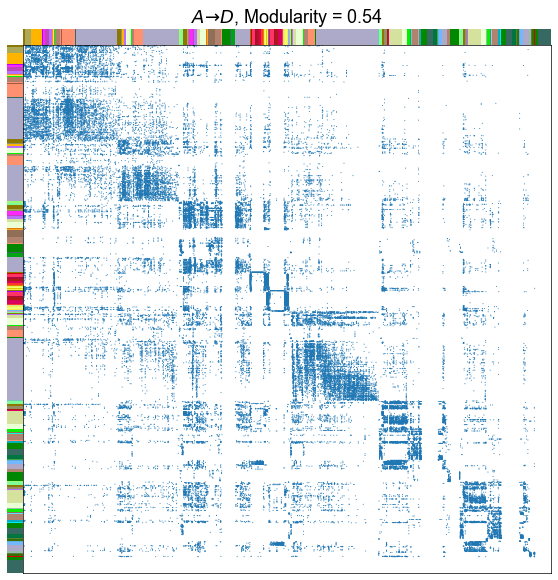

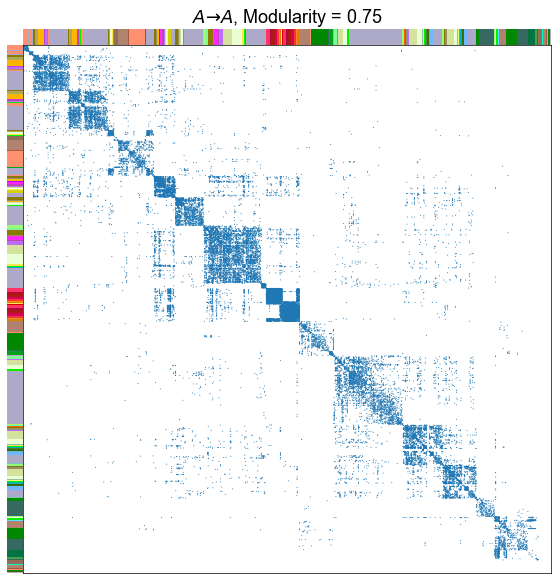

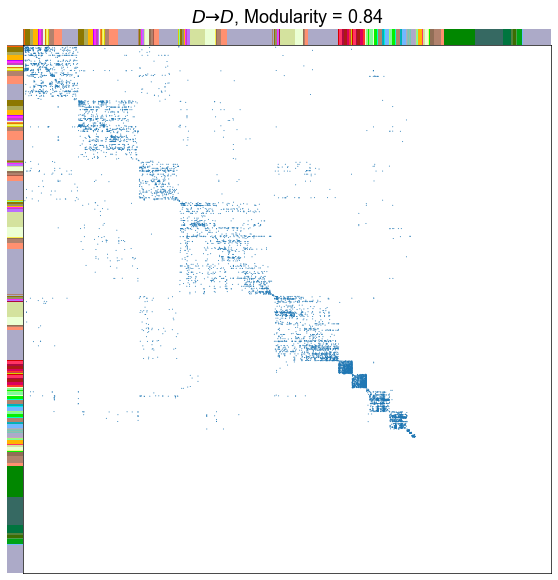

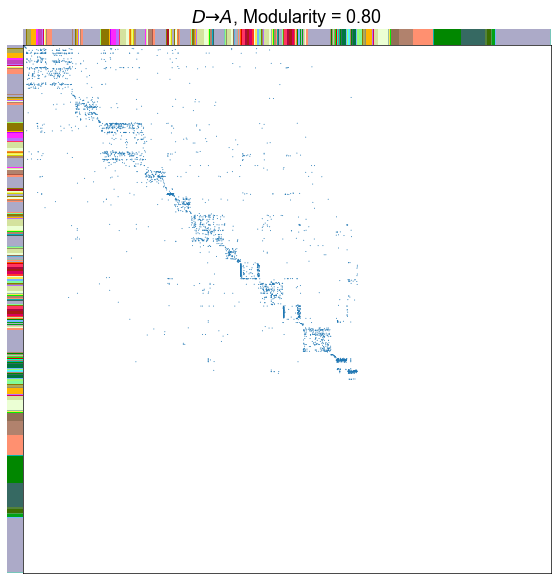

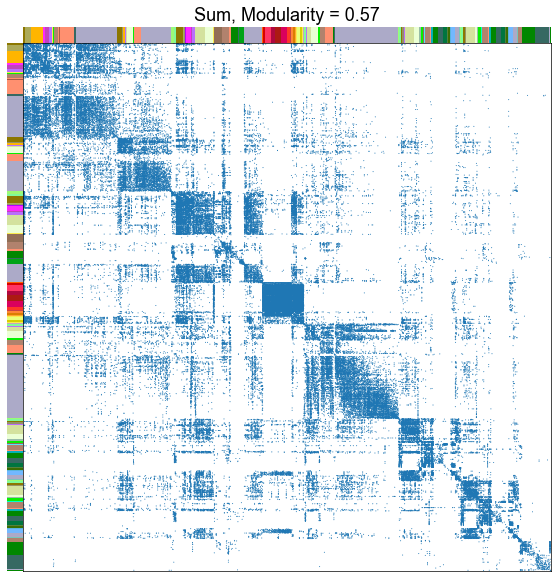

In [4]:
for _, row in results.iterrows():
    edge_type = row["edge_type"]
    nice_edge_type = nice_edge_types[edge_type]
    adj = row["adj"]
    meta = mg.nodes
    meta["partition"] = row["partition"]
    meta["partition"] = meta["partition"].fillna(-1)
    meta["is_unpartitioned"] = meta["partition"] == -1
    modularity_score = row["modularity_score"]
    adjplot(
        adj,
        meta=meta,
        sort_class="partition",
        class_order=["is_unpartitioned", "sf"],
        colors="merge_class",
        palette=palette,
        plot_type="scattermap",
        item_order=["merge_class", "sf"],
        ticks=False,
        sizes=(1, 2),
        gridline_kws=dict(linewidth=0),
        title=f"{nice_edge_type}, Modularity = {modularity_score:.2f}",
    )
    stashfig(f"modularity-sorted-adj-edge_type={edge_type}")

### Plot the modularity for each edge type

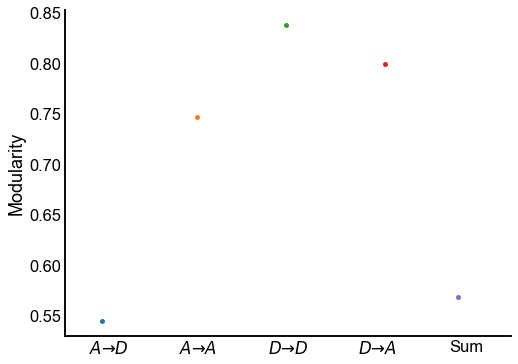

In [5]:
fig, ax = plt.subplots(1, 1, figsize=(8, 6))
sns.stripplot(
    data=results, jitter=True, x="nice_edge_type", y="modularity_score", ax=ax
)
ax.set(ylabel="Modularity", xlabel="")
stashfig("modularity-by-edge-type")

.. admonition:: Conclusion
The different edge types have distinct modularities (we should be able to get
p-values for this). In particular, the :math:`A \to D` seems the least modular.

### Plot the similarities between modularity-maximizing partitions

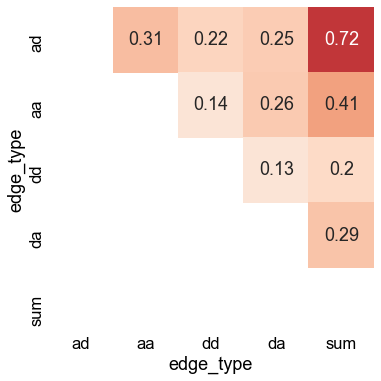

In [6]:


def compute_pairwise_ari(results):
    pairwise = pd.DataFrame(index=results.index, columns=results.index, dtype=float)
    # pairwise.index.name = None
    # pairwise.columns.name = None
    for idx1, row1 in results.iterrows():
        for idx2, row2 in results.iterrows():
            partition1 = row1["partition"]
            partition2 = row2["partition"]
            partition1 = np.array(partition1)
            partition2 = np.array(partition2)
            partition1[partition1 == None] = -1
            partition2[partition2 == None] = -1
            isvalid1 = partition1 != -1
            isvalid2 = partition2 != -1
            keep_inds = np.where(isvalid1 & isvalid2)[0]
            ari = adjusted_rand_score(partition1[keep_inds], partition2[keep_inds])
            pairwise.loc[idx1, idx2] = ari
    return pairwise


pairwise_ari = compute_pairwise_ari(results.set_index("edge_type"))

fig, ax = plt.subplots(1, 1, figsize=(6, 6))

inds = np.tril_indices(len(pairwise_ari), k=0)
mask = np.zeros((len(pairwise_ari), len(pairwise_ari)), dtype=bool)
mask[inds] = 1
sns.heatmap(
    pairwise_ari,
    ax=ax,
    square=True,
    annot=True,
    mask=mask,
    vmin=0,
    vmax=1,
    center=0,
    cmap="RdBu_r",
    cbar=False,
)
stashfig("pairwise-aris-modularity")

.. admonition:: Conclusion
The modularity-maximizing partitions between the different edge types are quite
different. Put another way, the "modules" you get by looking at each edge type
separately don't seem very similar. This did not have to be the case!

## End

In [7]:
elapsed = time.time() - t0
delta = datetime.timedelta(seconds=elapsed)
print("----")
print(f"Script took {delta}")
print(f"Completed at {datetime.datetime.now()}")
print("----")

----
Script took 0:03:28.690465
Completed at 2021-04-12 19:21:18.544766
----
